In [1]:
import xarray as xr 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import glob
from thesis_toolbox.utils import get_locations_CLP,read_depostion_datasets
from thesis_toolbox.plot.tools import add_letter
from thesis_toolbox.plot.plot_source_contribution import depositon_facet_plot
from matplotlib.colors import LogNorm
from matplotlib import rc
import matplotlib
import matplotlib.cm as cm
import numpy as np
%matplotlib inline
# latex_plot()

In [2]:
if 'snakemake' in globals():
    to_file = True
    path=f'{snakemake.config["old_base"]}/'
else:
    path = '../../../../../data/data/'
    to_file= False

In [3]:
def global_avg(ds):
    '''Calculates globally averaged values

    Parameters
    ----------
    ds : xarray.DaraArray i.e. ds[var]

    Returns
    -------
    ds_out :  xarray.DaraArray with globally averaged values
    '''
    # to include functionality for subsets or regional averages:
    if 'time' in ds.coords:
        weights = xr.apply_ufunc(np.cos,(xr.apply_ufunc(np.deg2rad,ds.lat))*ds.notnull().mean(dim=('lon','time')))
    else:
        weights = xr.apply_ufunc(np.cos,(xr.apply_ufunc(np.deg2rad,ds.lat))*ds.notnull().mean(dim=('lon')))
    ds_out = (ds.mean(dim='lon')*weights).sum(dim='lat')/weights.sum()
    if 'long_name'  in ds.attrs:
        ds_out.attrs['long_name']= 'Globally averaged ' + ds.long_name
    if 'units'  in ds.attrs:
        ds_out.attrs['units']=ds.units
    if 'standard_name'  in ds.attrs:
        ds_out.attrs['standard_name']=ds.standard_name
    return ds_out

In [4]:
def area_weighted_mean(da):
    """
    Calculate the area-weighted mean of an xarray DataArray, ignoring NaNs.

    Parameters:
    dataarray (xarray.DataArray): Input data array with latitude and longitude coordinates.

    Returns:
    xarray.DataArray: Area-weighted mean value.
    """

    weights = np.cos(np.deg2rad(da.lat))
    weights.name = "weights"

    da_weighted = da.weighted(weights)
    weighted_mean = da_weighted.mean(("lon", "lat"))

    return weighted_mean

In [5]:
def calc_fraction_of_mean_contribution(ds):
    out_ds = ds.copy()
    for dvar, da in ds.items():
        da = da.where(da > 0.0)
        dm = area_weighted_mean(da)
#         da = da.where(da > 0.0)
        da = da/dm
#         da = da.where(da == 1.0, 1.0)
        da = da.assign_attrs({'norm_fact': dm.values})
        out_ds = out_ds.assign({dvar:da})
    return out_ds, dm

In [6]:
def calc_ratio(ds_tot, ds_f):
    ds_out = ds_tot.copy()
    for dtvar, dvar in zip(ds_tot,ds_f):
        ds_out = ds_out.assign({dtvar: ds_f[dvar]/ds_tot[dtvar]})
    return ds_out

In [7]:
locs = ['SHAPOTOU','SACOL','BAODE','LUOCHUAN','LINGTAI','LANTIAN']
wetdep2m = read_depostion_datasets(path+'results/model_results/', locs, 'wetdep','2micron')
wetdep2m = wetdep2m.mean(dim='year')

drydep2m = read_depostion_datasets(path+'results/model_results/', locs, 'drydep', '2micron')
drydep2m = drydep2m.mean(dim='year')

wetdep20m = read_depostion_datasets(path+'results/model_results/', locs, 'wetdep','20micron')
wetdep20m = wetdep20m.mean(dim='year')

drydep20m = read_depostion_datasets(path+'results/model_results/', locs, 'drydep', '20micron')
drydep20m = drydep20m.mean(dim='year')

In [8]:
ratio_avg2m_wetdep, norm_fact_wd2m = calc_fraction_of_mean_contribution(wetdep2m)
ratio_avg2m_drydep, norm_fact_dd2m = calc_fraction_of_mean_contribution(drydep2m)
ratio_avg20m_wetdep,norm_fact_wd20m = calc_fraction_of_mean_contribution(wetdep20m)
ratio_avg20m_drydep,norm_fact_dd20m = calc_fraction_of_mean_contribution(drydep20m)

In [9]:

cm1 = ['#AA42BD','#E3EBB7','#2CC734']#2CC734
nodes = [0.0,0.5,1.0]
cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("cmap2", list(zip(nodes,cm1)))
cmap2.set_over('#228F32')

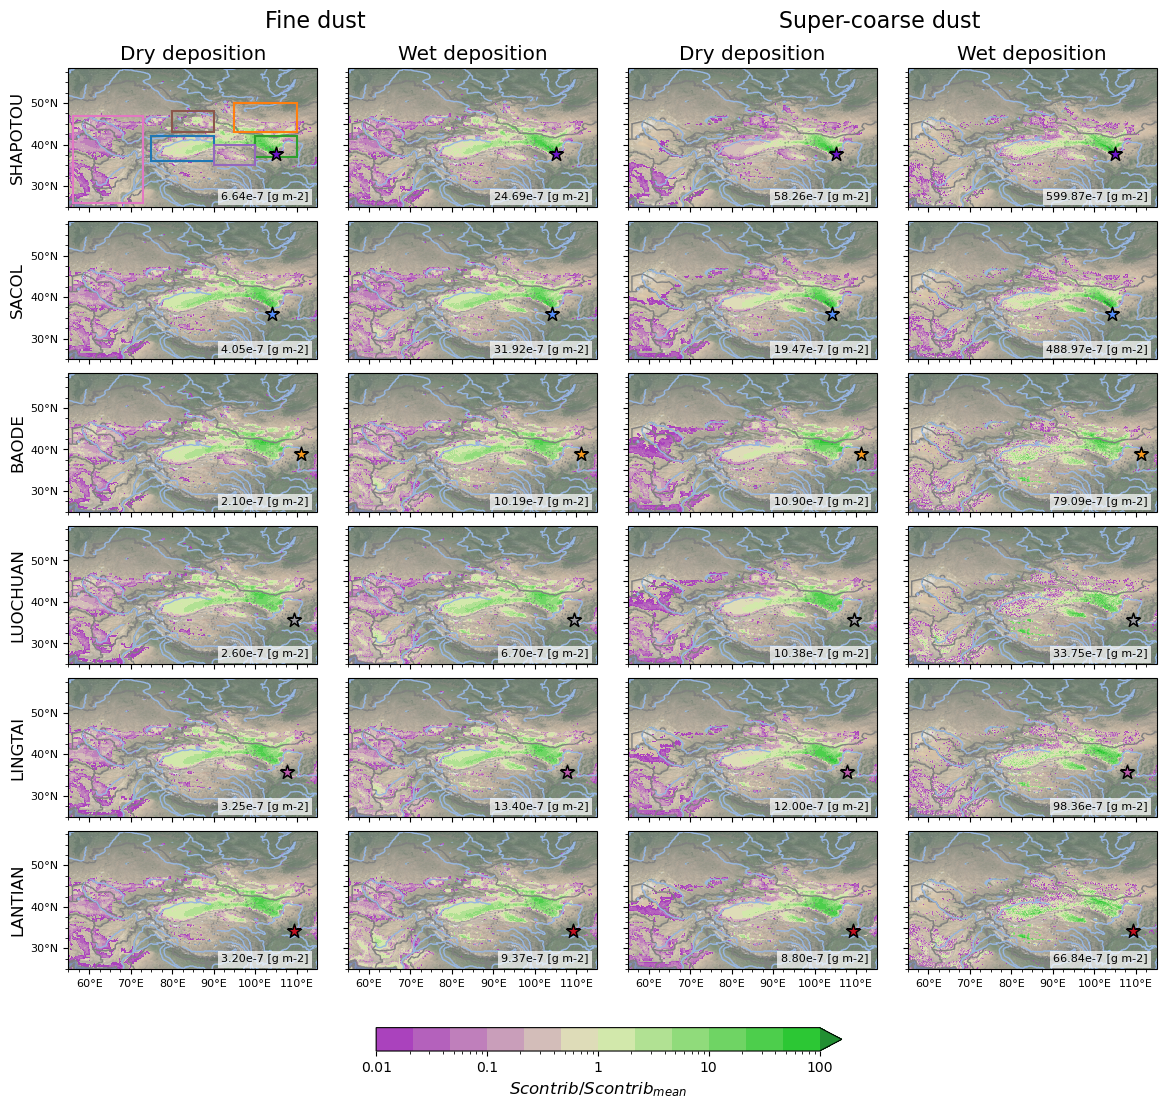

In [11]:
fig,ax = plt.subplots(nrows=6, ncols=4,  figsize=(8.3*1.7, 11.7), subplot_kw={'projection':ccrs.PlateCarree()})


cmap = cmap2.resampled(12)
depositon_facet_plot(ratio_avg2m_drydep,  
                    add_labels=False, ax=ax[:,0],  
                    fontsize_title=8, colorbar=False, vmin=1e-2,vmax=100,cmap=cmap,no_tick_labels=True, title=False, 
                     norm= matplotlib.colors.LogNorm(1e-2, 100), display_norm_fact=True)
depositon_facet_plot(ratio_avg2m_wetdep,  
                    add_labels=False, ax=ax[:,1]
                    ,norm=matplotlib.colors.LogNorm(1e-2, 100),  
                    fontsize_title=8, colorbar=False, vmin=1e-2,vmax=100,cmap=cmap,no_tick_labels=True, title=False,
                    display_norm_fact=True)
cax = fig.add_axes([0.345, 0.04,0.33,0.02])
cb = fig.colorbar(cm.ScalarMappable(norm=matplotlib.colors.LogNorm(1e-2, 100), cmap=cmap), cax=cax,
            label='$Scontrib/ Scontrib_{mean}$', orientation='horizontal', ticks=[0.01, 0.1, 1, 10, 100],  extend='max')
cb.ax.set_xticklabels([0.01, 0.1, 1, 10, 100])
depositon_facet_plot(ratio_avg20m_drydep,  
                    add_labels=False, ax=ax[:,2]
                    , hspace=0.05, wspace=0.1,  
                    fontsize_title=8, colorbar=False, vmin=1e-2,vmax=100,cmap=cmap,no_tick_labels=True, title=False,
                    display_norm_fact=True)
depositon_facet_plot(ratio_avg20m_wetdep,  
                    add_labels=False, ax=ax[:,3]
                    , hspace=0.05, wspace=0.1,  
                    fontsize_title=8, colorbar=False, vmin=1e-2,vmax=100,cmap=cmap,no_tick_labels=True, title=False,
                    display_norm_fact=True)
for axi in ax.ravel():
    axi.set_extent([55,115,25,55])
    axi.set_xticks([60,70, 80, 90, 100, 110])
    axi.yaxis.set_ticklabels([])
    axi.xaxis.set_ticklabels([])
for axi,l in zip(ax[:,0].ravel(),locs):
    axi.set_ylabel(l)
    axi.set_yticks([30, 40, 50])
    axi.yaxis.set_ticklabels(['30°N', '40°N', '50°N'], fontsize=8)

for axi in ax[-1,:].ravel():
    axi.set_xticks([60,70, 80, 90, 100, 110])
    axi.xaxis.set_ticklabels(['60°E','70°E','80°E', '90°E', '100°E', '110°E'], fontsize=8)

ax_i = ax[0,0] 
ax_i.add_patch(matplotlib.patches.Rectangle(xy=[75,36],width=15,height=6, transform=ccrs.PlateCarree(),
                                            fill=False,linewidth=1.5, edgecolor='tab:blue',zorder=2000))
ax_i.add_patch(matplotlib.patches.Rectangle(xy=[100,37],width=10,height=5, transform=ccrs.PlateCarree(),
                                            fill=False,linewidth=1.5, edgecolor='tab:green',zorder=1250))
ax_i.add_patch(matplotlib.patches.Rectangle(xy=[95,43],width=15,height=7, transform=ccrs.PlateCarree(),
                                            fill=False,linewidth=1.5, edgecolor='tab:orange',zorder=2000))
ax_i.add_patch(matplotlib.patches.Rectangle(xy=[80,43],width=10,height=5, transform=ccrs.PlateCarree(),
                                            fill=False,linewidth=1.5, edgecolor='tab:brown',zorder=2000))
ax_i.add_patch(matplotlib.patches.Rectangle(xy=[90,35],width=10,height=5, transform=ccrs.PlateCarree(),
                                            fill=False,linewidth=1.5, edgecolor='tab:purple',zorder=2000))
ax_i.add_patch(matplotlib.patches.Rectangle(xy=[56,26],width=17,height=21, transform=ccrs.PlateCarree(),
                                            fill=False,linewidth=1.5, edgecolor='tab:pink', zorder=2000))

fig.suptitle('Fine dust                                                          Super-coarse dust',x=0.52, y=0.92, ha='center', va='center', fontsize=16)

fig.subplots_adjust(hspace=0.1, wspace=0.1)

ax[0,0].set_title('Dry deposition')
ax[0,1].set_title('Wet deposition')
ax[0,2].set_title('Dry deposition')
ax[0,3].set_title('Wet deposition')

if to_file:
    plt.savefig(snakemake.output.combopath,bbox_inches='tight', dpi=300)